In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas
import plotly.express as px

import os 
import sys 
import re
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
grid_search_fileNames = os.listdir('./save_samplesize/')
grid_search_filePaths = [os.path.join('./save_samplesize/',i) for i in grid_search_fileNames]

In [3]:
train_stats_samples_all = []

def tmp_fun(filePath):
    res = torch.load(filePath)
    return({**res['args'], 'test_accu_record': res['train_stats']['test_accu_record']})

train_stats_samples_all = Parallel(n_jobs=32)(delayed(tmp_fun)(i) for i in tqdm(grid_search_filePaths))

100%|██████████| 27/27 [00:00<00:00, 2270.78it/s]


In [23]:
samplesize = []
final_test_accu = []
for i in train_stats_samples_all:
    samplesize.append(i['num_pairs_per_user'])
    final_test_accu.append(i['test_accu_record'][-1])

In [24]:
samplesize, final_test_accu = list(zip(*sorted(zip(samplesize,final_test_accu))))

Text(0.5, 1.0, 'Color Preference Prediction Accuracy')

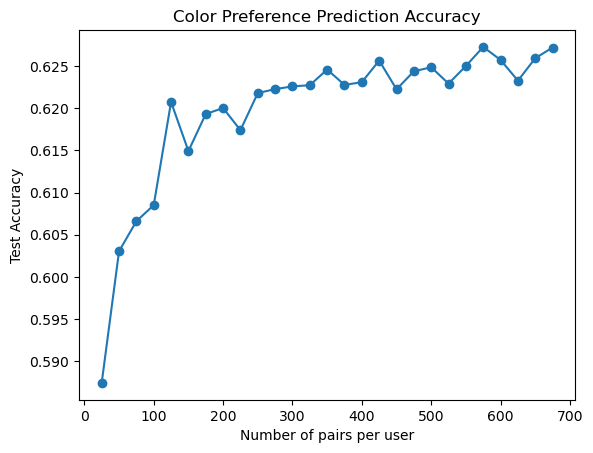

In [25]:
fig,ax = plt.subplots()
ax.plot(samplesize,final_test_accu, '-o')
ax.set_xlabel('Number of pairs per user')
ax.set_ylabel('Test Accuracy')
ax.set_title('Color Preference Prediction Accuracy')

# Metric singular value check

In [2]:
grid_search_fileNames = os.listdir('./save_samplesize/')
grid_search_filePaths = [os.path.join('./save_samplesize/',i) for i in grid_search_fileNames]
res_list = [torch.load(filePath) for filePath in tqdm(grid_search_filePaths)]

100%|██████████| 27/27 [04:25<00:00,  9.85s/it]


In [4]:
sample_size = []
final_test_accu = []
final_relative_metric_error = []
final_relative_ideal_point_error = []
final_learner = []
for i in res_list:
    sample_size.append(i['args']['num_pairs_per_user'])
    final_test_accu.append(i['train_stats']['test_accu_record'][-1])
    # final_relative_metric_error.append(i['train_stats']['relative_metric_error_record'][-1])
    # final_relative_ideal_point_error.append(i['train_stats']['relative_ideal_point_error_record'][-1])
    final_learner.append(i['learner'])

In [5]:

pred_M_list = []
pred_U_list = []
singular_list = []

for i in final_learner:
    pred_L = i.model.layers.weight.detach().numpy()
    pred_M_list.append(pred_L.T @ pred_L)
    pred_U_list.append(i.us.detach().numpy())
    U, S, Vh = np.linalg.svd(pred_L.T @ pred_L)
    singular_list.append(S)

In [6]:
sample_size,final_test_accu, final_learner = list(zip(*sorted(zip(sample_size,final_test_accu,final_learner))))

Text(0.5, 1.0, 'The singular values of $\\hat{M}$ with different num_pairs_per_user (Color dataset)')

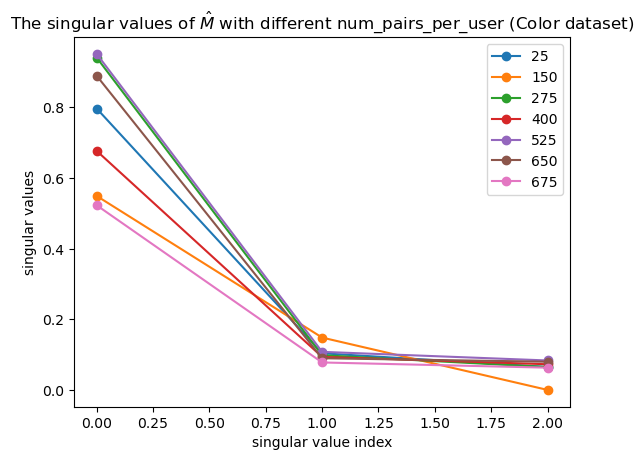

In [7]:
fig,ax = plt.subplots()

for i in [0,5,10,15,20,25,-1]:
    ax.plot(np.array(singular_list)[i,:],'-o',label=sample_size[i])
ax.legend()

ax.set_xlabel('singular value index')
ax.set_ylabel('singular values')
ax.set_title('The singular values of $\hat{M}$ with different num_pairs_per_user (Color dataset)')

In [8]:
sample_size[-1]

675

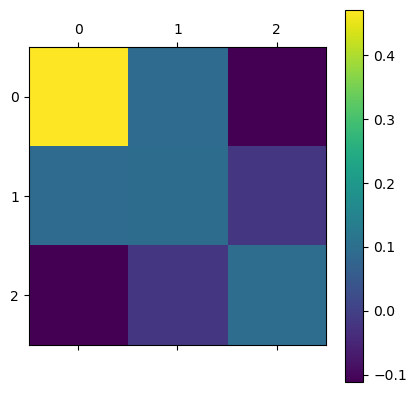

In [9]:
plt.matshow(pred_M_list[-1])
plt.colorbar()

In [22]:
df = pandas.DataFrame(pred_U_list[-1].T)
fig = px.scatter_3d(df,x=0,y=1,z=2)
fig.show()

In [23]:
df = pandas.DataFrame(pred_U_list[0].T)
fig = px.scatter_3d(df,x=0,y=1,z=2)
fig.show()